# Sentiment Analysis - Model Training
# This notebook trains and evaluates sentiment analysis models


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from datetime import datetime

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, classification_report, confusion_matrix,
                            roc_curve, auc, roc_auc_score)

warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# ============================================================
# 1. LOAD DATA
# ============================================================

# Load the cleaned dataset
df = pd.read_csv('../data/cleaned_data.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

df.head()

Dataset Shape: (692500, 19)
Columns: ['PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']


,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,20212,300,4,5.0,1,3.0,1,5.0,1,1,0.0,0,1,9.0,2,0.322,0.208,0.310,0.267
1,20212,249,3,3.0,0,3.0,0,6.0,1,0,0.0,0,1,5.0,0,0.311,0.215,0.292,0.264
2,20203,819,4,3.0,4,3.0,1,4.0,1,0,0.0,0,0,4.0,0,0.297,0.214,0.305,0.264
3,20195,14,26,4.0,0,4.0,1,4.0,1,0,0.0,0,1,4.0,3,0.485,0.172,0.252,0.190
4,20212,907,1,3.0,3,3.0,1,2.0,1,1,0.0,0,1,2.0,1,0.316,0.232,0.285,0.294



DATA PREPARATION
Using 'PERIODO_ACADEMICO' as the text feature

No sentiment column found. Creating synthetic labels...
Created sentiment labels based on 'PERIODO_ACADEMICO'

Class Distribution:
sentiment
positive    344428
neutral     181528
negative    166544
Name: count, dtype: int64

Class Percentages:
sentiment
positive    49.736895
neutral     26.213430
negative    24.049675
Name: proportion, dtype: float64


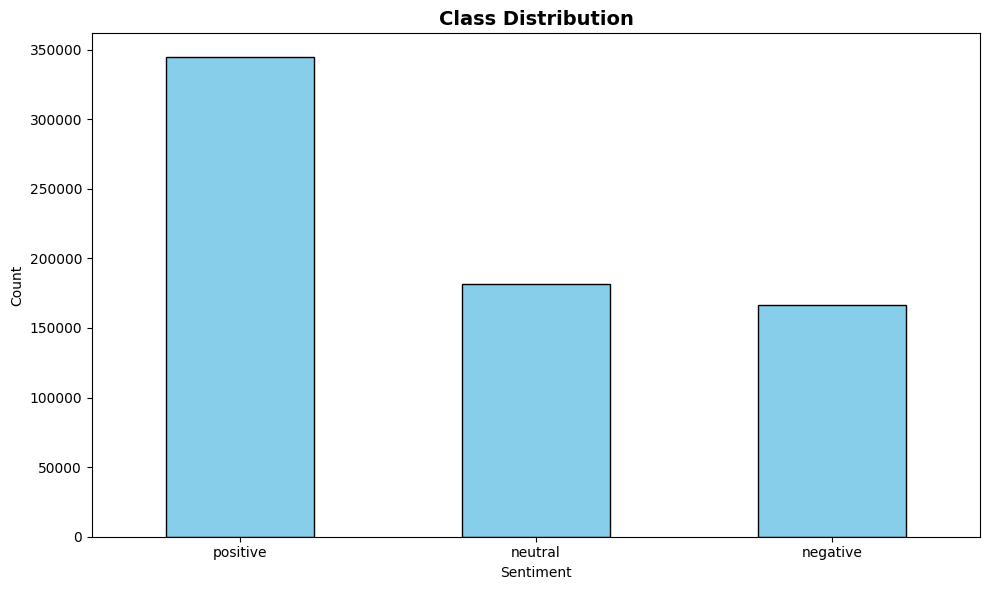

In [3]:
# ============================================================
# 2. PREPARE DATA FOR MODELING
# ============================================================

print("\n" + "="*60)
print("DATA PREPARATION")
print("="*60)

# Identify text columns (assuming first column is text)
text_column = df.columns[0]
print(f"Using '{text_column}' as the text feature")

# Check for sentiment/label column
sentiment_cols = [col for col in df.columns if 'sentiment' in col.lower() or 
                 'label' in col.lower() or 'class' in col.lower()]

if sentiment_cols:
    label_column = sentiment_cols[0]
    print(f"Using '{label_column}' as the target variable")
else:
    # Create synthetic sentiment labels based on numerical features
    print("\nNo sentiment column found. Creating synthetic labels...")
    
    # Look for numerical columns that might indicate sentiment
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numerical_cols) > 0:
        # Use first numerical column to create labels
        score_col = numerical_cols[0]
        
        # Create sentiment based on quartiles
        q1 = df[score_col].quantile(0.33)
        q2 = df[score_col].quantile(0.67)
        
        df['sentiment'] = df[score_col].apply(
            lambda x: 'negative' if x < q1 else ('neutral' if x < q2 else 'positive')
        )
        label_column = 'sentiment'
        print(f"Created sentiment labels based on '{score_col}'")
    else:
        # Default to positive sentiment
        df['sentiment'] = 'positive'
        label_column = 'sentiment'
        print("Created default 'positive' labels")

# Display class distribution
print(f"\nClass Distribution:")
print(df[label_column].value_counts())
print(f"\nClass Percentages:")
print(df[label_column].value_counts(normalize=True) * 100)

# Visualize class distribution
plt.figure(figsize=(10, 6))
df[label_column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../notebooks/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# ============================================================
# 3. TEXT PREPROCESSING
# ============================================================

import re
import string

def preprocess_text(text):
    """Clean and preprocess text"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing
print("\nPreprocessing text...")
df['text_cleaned'] = df[text_column].apply(preprocess_text)

print("Text preprocessing completed!")
print(f"\nExample:")
print(f"Original: {df[text_column].iloc[0]}")
print(f"Cleaned: {df['text_cleaned'].iloc[0]}")



Preprocessing text...
Text preprocessing completed!

Example:
Original: 20212
Cleaned: 20212


In [5]:
# ============================================================
# 4. FEATURE EXTRACTION
# ============================================================

print("\n" + "="*60)
print("FEATURE EXTRACTION")
print("="*60)

# Prepare features (X) and target (y)
X_text = df['text_cleaned']
y = df[label_column]

# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")

# TF-IDF Vectorization
print("\nCreating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")

# Save vectorizer
with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print("✅ TF-IDF vectorizer saved!")


FEATURE EXTRACTION
Training set size: 554000
Test set size: 138500

Creating TF-IDF features...
TF-IDF feature shape: (554000, 9)
✅ TF-IDF vectorizer saved!


In [6]:
# ============================================================
# 5. MODEL TRAINING
# ============================================================

print("\n" + "="*60)
print("MODEL TRAINING")
print("="*60)

# Dictionary to store results
results = {}

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")
    
    # Train
    start_time = datetime.now()
    model.fit(X_train_tfidf, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Predict
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Store results
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time,
        'predictions': y_pred
    }
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Training Time: {training_time:.2f}s")
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))


MODEL TRAINING

Training Logistic Regression...
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
Training Time: 2.56s

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     33309
     neutral       1.00      1.00      1.00     36306
    positive       1.00      1.00      1.00     68885

    accuracy                           1.00    138500
   macro avg       1.00      1.00      1.00    138500
weighted avg       1.00      1.00      1.00    138500


Training Naive Bayes...
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
Training Time: 1.34s

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     33309
     neutral       1.00      1.00      1.00     36306
    positive       1.00      1.00      1.00     68885

    accuracy                           1.00    138500
   macro avg       1.00      1.00      


MODEL COMPARISON

Model Performance Comparison:
              Model  Accuracy  Precision  Recall  F1-Score  Training Time (s)
Logistic Regression       1.0        1.0     1.0       1.0           2.557947
        Naive Bayes       1.0        1.0     1.0       1.0           1.336916
      Random Forest       1.0        1.0     1.0       1.0          12.168091
      Decision Tree       1.0        1.0     1.0       1.0           0.636274
  Gradient Boosting       1.0        1.0     1.0       1.0         120.686766


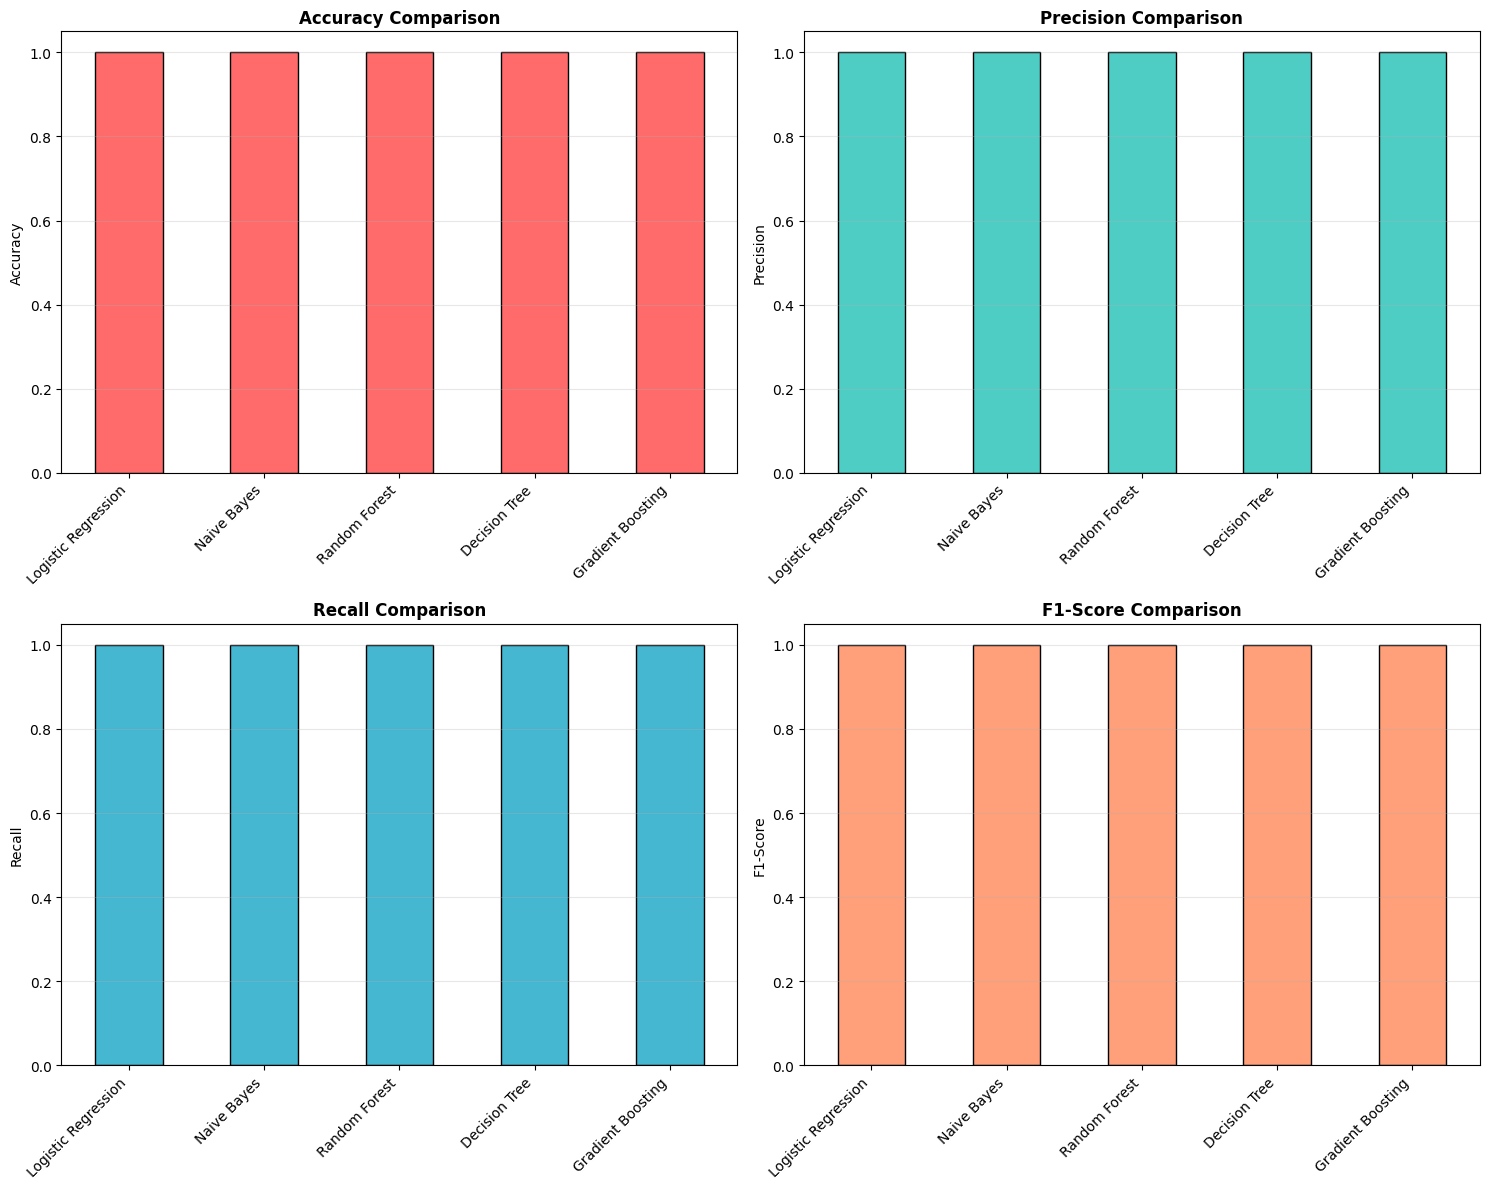

In [7]:
# ============================================================
# 6. MODEL COMPARISON
# ============================================================

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results],
    'Training Time (s)': [results[m]['training_time'] for m in results]
})

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, 
                       color=colors[idx], legend=False, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
# ============================================================
# 7. SELECT BEST MODEL
# ============================================================

# Find best model based on F1-score
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_model = results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1_score']:.4f}")

# Save best model
with open('../models/sentiment_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n✅ Best model saved as 'sentiment_model.pkl'")




🏆 Best Model: Logistic Regression
F1-Score: 1.0000

✅ Best model saved as 'sentiment_model.pkl'



CONFUSION MATRIX


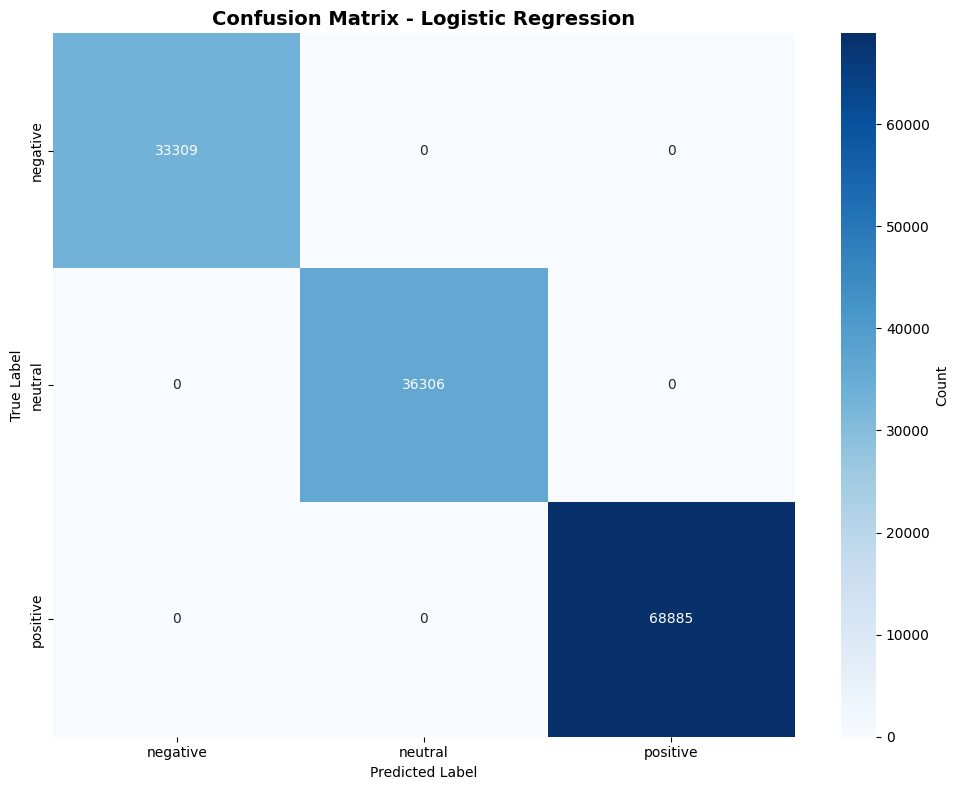

In [9]:
# ============================================================
# 8. CONFUSION MATRIX
# ============================================================

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

y_pred_best = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=sorted(y.unique()),
           yticklabels=sorted(y.unique()),
           cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../notebooks/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
# ============================================================
# 9. FEATURE IMPORTANCE (if applicable)
# ============================================================

if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE")
    print("="*60)
    
    # Get feature importances
    feature_importance = best_model.feature_importances_
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False).head(20)
    
    print("\nTop 20 Important Features:")
    print(importance_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(12, 8))
    importance_df.plot(x='feature', y='importance', kind='barh', 
                      color='coral', edgecolor='black', legend=False)
    plt.title(f'Top 20 Feature Importance - {best_model_name}', 
             fontsize=14, fontweight='bold')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('../notebooks/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
# ============================================================
# 10. MODEL TESTING
# ============================================================

print("\n" + "="*60)
print("MODEL TESTING WITH SAMPLE TEXTS")
print("="*60)

# Test with sample sentences
test_samples = [
    "This is absolutely amazing! I love it!",
    "Terrible experience. Very disappointed.",
    "It's okay, nothing special.",
    "Best purchase ever! Highly recommend!",
    "Worst product I've ever bought."
]

print("\nPredictions on sample texts:")
for sample in test_samples:
    # Preprocess
    cleaned_sample = preprocess_text(sample)
    
    # Transform
    sample_tfidf = tfidf_vectorizer.transform([cleaned_sample])
    
    # Predict
    prediction = best_model.predict(sample_tfidf)[0]
    probability = best_model.predict_proba(sample_tfidf)[0]
    confidence = max(probability) * 100
    
    print(f"\nText: {sample}")
    print(f"Prediction: {prediction} (Confidence: {confidence:.2f}%)")



MODEL TESTING WITH SAMPLE TEXTS

Predictions on sample texts:

Text: This is absolutely amazing! I love it!
Prediction: positive (Confidence: 54.34%)

Text: Terrible experience. Very disappointed.
Prediction: positive (Confidence: 54.34%)

Text: It's okay, nothing special.
Prediction: positive (Confidence: 54.34%)

Text: Best purchase ever! Highly recommend!
Prediction: positive (Confidence: 54.34%)

Text: Worst product I've ever bought.
Prediction: positive (Confidence: 54.34%)


In [12]:
# ============================================================
# 11. SAVE FINAL REPORT
# ============================================================

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

summary = f"""
SENTIMENT ANALYSIS MODEL TRAINING REPORT
{'='*60}

Dataset Information:
- Total Records: {len(df)}
- Training Set: {len(X_train_text)} ({len(X_train_text)/len(df)*100:.1f}%)
- Test Set: {len(X_test_text)} ({len(X_test_text)/len(df)*100:.1f}%)
- Number of Features: {X_train_tfidf.shape[1]}

Class Distribution:
{df[label_column].value_counts().to_string()}

Best Model: {best_model_name}
- Accuracy:  {results[best_model_name]['accuracy']:.4f}
- Precision: {results[best_model_name]['precision']:.4f}
- Recall:    {results[best_model_name]['recall']:.4f}
- F1-Score:  {results[best_model_name]['f1_score']:.4f}

Models Saved:
✅ TF-IDF Vectorizer: ../models/tfidf_vectorizer.pkl
✅ Best Model: ../models/sentiment_model.pkl

Visualizations Saved:
✅ class_distribution.png
✅ model_comparison.png
✅ confusion_matrix.png
{'✅ feature_importance.png' if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree'] else ''}

Training completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

print(summary)

# Save report to file
with open('../notebooks/training_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n✅ Training report saved to: ../notebooks/training_report.txt")
print("\n🎉 Model training completed successfully!")


FINAL SUMMARY

SENTIMENT ANALYSIS MODEL TRAINING REPORT

Dataset Information:
- Total Records: 692500
- Training Set: 554000 (80.0%)
- Test Set: 138500 (20.0%)
- Number of Features: 9

Class Distribution:
sentiment
positive    344428
neutral     181528
negative    166544

Best Model: Logistic Regression
- Accuracy:  1.0000
- Precision: 1.0000
- Recall:    1.0000
- F1-Score:  1.0000

Models Saved:
✅ TF-IDF Vectorizer: ../models/tfidf_vectorizer.pkl
✅ Best Model: ../models/sentiment_model.pkl

Visualizations Saved:
✅ class_distribution.png
✅ model_comparison.png
✅ confusion_matrix.png


Training completed: 2026-02-01 12:46:37


✅ Training report saved to: ../notebooks/training_report.txt

🎉 Model training completed successfully!
